# Imports & Load Data
作業に必要なライブラリをインポートして、 以下のデータを読み込みます。

* stock_price : 株価情報
* stock_list : 銘柄情報
* stock_fin : 財務諸表
* stock_labels : 目的変数

In [1]:
!pip install keras
!pip install tensorflow

In [1]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import  xgboost as xgb
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm

# Sequentialのインポート
from keras.models import Sequential
# Dense、LSTMのインポート
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation
import keras
from scipy import stats
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import PReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [2]:
# python 3.7.3であることを確認します
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [3]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="/path/to"

In [4]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    #"stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


# 特徴量の生成

In [5]:
FEATURES = ['MA_gap_2month',
            'MA_gap_3month',
            'volatility_2month',
            'volatility_3month',
            'Result_Dividend FiscalYear',
            'return_3month',
            'Forecast_Dividend FiscalYear',
            'volatility_1month',
            'Forecast_FinancialStatement FiscalYear',
            'MA_gap_1month',
            'pbr',
            'Result_FinancialStatement FiscalYear',
            'return_1month',
            'ema_12',
            'Result_FinancialStatement TotalAssets',
            'signal',
            'Previous_FinancialStatement NetIncome',
            'per',
            'Result_FinancialStatement CashFlowsFromOperatingActivities',
            'Result_FinancialStatement CashFlowsFromInvestingActivities',
            'ema_10']

In [6]:
def get_feature_columns(dfs, train_X, column_group="fundamental+technical"):
    # 特徴量グループを定義
    # ファンダメンタル
    fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
    fundamental_cols = fundamental_cols[
        fundamental_cols != "Result_Dividend DividendPayableDate"
        ]
    fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
    # 価格変化率
    returns_cols = [x for x in train_X.columns if "return" in x]
    # テクニカル
    technical_cols = [
        x for x in train_X.columns if
        (x not in fundamental_cols) and (x != "code")
    ]
    columns = {
        "fundamental_only": fundamental_cols,
        "return_only": returns_cols,
        "technical_only": technical_cols,
        "fundamental+technical": list(fundamental_cols) + list(
            technical_cols),
        "selected_columns":FEATURES,
    }
    return columns[column_group]

In [7]:
model_path = os.path.join(os.path.dirname("__file__"), "../model")
test_X_path = os.path.join(os.path.dirname("__file__"), "../../new_data_dir/test_X")
test_y_path = os.path.join(os.path.dirname("__file__"), "../../new_data_dir/test_y")
val_X_path = os.path.join(os.path.dirname("__file__"), "../../new_data_dir/val_X")
val_y_path = os.path.join(os.path.dirname("__file__"), "../../new_data_dir/val_y")
train_X_path = os.path.join(os.path.dirname("__file__"), "../../new_data_dir/train_X")
train_y_path = os.path.join(os.path.dirname("__file__"), "../../new_data_dir/train_y")

In [8]:
# 対象の目的変数を定義
labels = {
#    "label_high_5",
#    "label_high_10",
    "label_high_20",
#    "label_low_5",
#    "label_low_10",
    "label_low_20",
}

In [9]:
# 特徴量追加済みデータ
proceed_datas = {
    "train_X",
    "train_y",
    "val_X",
    "val_y",
    "test_X",
    "test_y"
}

In [10]:
label = 'label_high_20'
data_X = os.path.join(train_X_path, f"train_X_{label}.pkl")
with open(data_X , "rb") as f:
    train_X = pickle.load(f)
data_y = os.path.join(train_y_path, f"train_y_{label}.pkl")
with open(data_y , "rb") as f:
    train_y = pickle.load(f)
    
data_X = os.path.join(test_X_path, f"test_X_{label}.pkl")
with open(data_X , "rb") as f:
    test_X = pickle.load(f)
data_y = os.path.join(test_y_path, f"test_y_{label}.pkl")
with open(data_y , "rb") as f:
    test_y = pickle.load(f)
    
data_X = os.path.join(val_X_path, f"val_X_{label}.pkl")
with open(data_X , "rb") as f:
    val_X = pickle.load(f)
data_y = os.path.join(val_y_path, f"val_y_{label}.pkl")
with open(data_y , "rb") as f:
    val_y = pickle.load(f)

In [11]:
train_X = train_X.drop(columns=["code", "Result_FinancialStatement FiscalYear", "Forecast_FinancialStatement FiscalYear", 
"Result_Dividend FiscalYear", "Forecast_Dividend FiscalYear", "Section/Products",
"33 Sector(Code)", "17 Sector(Code)","Result_FinancialStatement CashFlowsFromOperatingActivities",
"Result_FinancialStatement CashFlowsFromFinancingActivities",
"Result_FinancialStatement CashFlowsFromInvestingActivities",
"Previous_FinancialStatement CashFlowsFromOperatingActivities",
"Previous_FinancialStatement CashFlowsFromFinancingActivities",
"Previous_FinancialStatement CashFlowsFromInvestingActivities","IssuedShareEquityQuote IssuedShare"])
test_X = test_X.drop(columns=["code", "Result_FinancialStatement FiscalYear", "Forecast_FinancialStatement FiscalYear", 
"Result_Dividend FiscalYear", "Forecast_Dividend FiscalYear", "Section/Products",
"33 Sector(Code)", "17 Sector(Code)","Result_FinancialStatement CashFlowsFromOperatingActivities",
"Result_FinancialStatement CashFlowsFromFinancingActivities",
"Result_FinancialStatement CashFlowsFromInvestingActivities",
"Previous_FinancialStatement CashFlowsFromOperatingActivities",
"Previous_FinancialStatement CashFlowsFromFinancingActivities",
"Previous_FinancialStatement CashFlowsFromInvestingActivities","IssuedShareEquityQuote IssuedShare"])
val_X = val_X.drop(columns=["code", "Result_FinancialStatement FiscalYear", "Forecast_FinancialStatement FiscalYear", 
"Result_Dividend FiscalYear", "Forecast_Dividend FiscalYear", "Section/Products",
"33 Sector(Code)", "17 Sector(Code)","Result_FinancialStatement CashFlowsFromOperatingActivities",
"Result_FinancialStatement CashFlowsFromFinancingActivities",
"Result_FinancialStatement CashFlowsFromInvestingActivities",
"Previous_FinancialStatement CashFlowsFromOperatingActivities",
"Previous_FinancialStatement CashFlowsFromFinancingActivities",
"Previous_FinancialStatement CashFlowsFromInvestingActivities","IssuedShareEquityQuote IssuedShare"])

In [12]:
train_X.columns

Index(['return_1month', 'return_2month', 'return_3month', 'volatility_1month', 'volatility_2month',
       'volatility_3month', 'MA_gap_1month', 'MA_gap_2month', 'MA_gap_3month', 'EWMA', 'ema_10', 'ema_12', 'ema_26',
       'macd', 'signal', 'pbr', 'per', 'Result_FinancialStatement NetSales',
       'Result_FinancialStatement OperatingIncome', 'Result_FinancialStatement OrdinaryIncome',
       'Result_FinancialStatement NetIncome', 'Result_FinancialStatement TotalAssets',
       'Result_FinancialStatement NetAssets', 'Forecast_FinancialStatement NetSales',
       'Forecast_FinancialStatement OperatingIncome', 'Forecast_FinancialStatement OrdinaryIncome',
       'Forecast_FinancialStatement NetIncome', 'Result_Dividend QuarterlyDividendPerShare',
       'Result_Dividend AnnualDividendPerShare', 'Forecast_Dividend QuarterlyDividendPerShare',
       'Forecast_Dividend AnnualDividendPerShare', 'Previous_FinancialStatement NetSales',
       'Previous_FinancialStatement OperatingIncome', 'Pr

In [13]:
train_X = stats.zscore(train_X)
test_X = stats.zscore(test_X)
val_X = stats.zscore(val_X)

In [14]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [15]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

In [16]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape

((64142, 1, 49), (64142,), (2579, 1, 49), (2579,), (15731, 1, 49), (15731,))

In [17]:
# 以下、ネットワークを構築
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(.2))

model.add(Dense(256))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.1))

model.add(Dense(256))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.1))

model.add(Dense(128))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(64))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(32))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(16))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))
model.add(Activation("linear"))

# 出力層
model.add(Dense(1))
# ネットワークのコンパイル
model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.001), metrics=['mse'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1150976   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
p_re_lu (PReLU)              (None, 256)               256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [19]:
callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
        ]

In [20]:
result = model.fit(x=train_X, y=train_y, epochs=1000, validation_data=(val_X, val_y),  callbacks=callbacks)

Epoch 1/1000
2005/2005 [==============================] - 25s 12ms/step - loss: 0.0970 - mse: 0.0970 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 2/1000
2005/2005 [==============================] - 24s 12ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 3/1000
2005/2005 [==============================] - 24s 12ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 4/1000
2005/2005 [==============================] - 24s 12ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 5/1000
2005/2005 [==============================] - 24s 12ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 6/1000
2005/2005 [==============================] - 24s 12ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 7/1000
2005/2005 [==============================] - 24s 12ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 8/1000
2005/2005 [==========

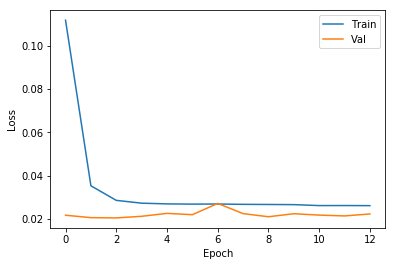

In [26]:
# matplotlibのインポート
from matplotlib import pyplot as plt

# 折れ線グラフによる学習データの損失の描画
plt.plot(result.history['loss'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result.history['val_loss'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 描画の実行
plt.show()

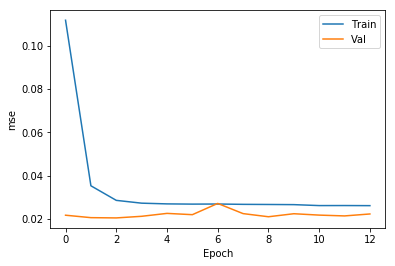

In [27]:
# 折れ線グラフによる学習データの損失の描画
plt.plot(result.history['mse'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result.history['val_mse'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('mse')

# 描画の実行
plt.show()

In [28]:
loss, accuracy = model.evaluate(test_X, test_y)

81/81 [==============================] - 0s 4ms/step - loss: 0.0324 - mse: 0.0324


In [29]:
# 評価データの正解率の表示
print('評価データの正解率:', accuracy)

評価データの正解率: 0.032399244606494904


In [30]:
loss

0.032399244606494904

In [31]:
pred = model.predict(test_X)

In [32]:
test_y.head(10)

datetime
2021-02-01    0.04381
2021-02-10    0.00676
2021-02-10    0.12026
2021-02-05    0.04636
2021-02-12   -0.00321
2021-02-08    0.00000
2021-02-10    0.15130
2021-02-12    0.03550
2021-02-08    0.13965
2021-02-05    0.12130
Name: label_high_20, dtype: float64

In [33]:
test_y.mean()

0.09155197363319112

In [34]:
pred[:10]

array([[0.02971584],
       [0.1414432 ],
       [0.09382368],
       [0.03134373],
       [0.09985893],
       [0.05083916],
       [0.10141297],
       [0.05889008],
       [0.03452037],
       [0.06321989]], dtype=float32)

In [35]:
np.average(pred)

0.087012574

In [36]:
spearmanr(test_y, pred)[0]

0.07216389577342798